### ChagaSight — Vision Transformer (Baseline Training)

Baseline ViT training on 2D ECG contour images  
Datasets: PTB-XL (negatives), SaMi-Trop (positives), CODE-15 (soft labels)

Baseline configuration:
- 1% subset (pipeline verification)
- No data augmentation
- AMP enabled
- Strict data integrity checks


In [1]:
# =========================
# CELL 1 (Code) — Setup, device, paths, seed
# =========================

import time, random, sys
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import torch

start_time = time.time()

# -------------------------
# Reproducibility (Baseline-Safe)
# -------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Deterministic baseline (Crucial for medical AI research)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------
# Device Configuration
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))
    print("VRAM (GB):", torch.cuda.get_device_properties(0).total_memory / 1e9)

# -------------------------
# Universal Project Root Detection
# -------------------------
def find_project_root(start: Path) -> Path:
    """Finds the directory containing the 'data' folder."""
    for p in [start] + list(start.parents):
        if (p / "data").exists():
            return p
    return start

# Set current working directory based on the notebook location
PROJECT_ROOT = find_project_root(Path.cwd())
DATA_DIR = PROJECT_ROOT / "data" / "processed"

# Add project root to sys.path for importing local src modules
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

# -------------------------
# Experiment Management
# -------------------------
# Final year project name aligned with research papers
EXP_NAME = "vit_contour_baseline" 
RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
EXP_DIR = PROJECT_ROOT / "experiments" / EXP_NAME / RUN_ID
EXP_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR)
print("Experiment directory:", EXP_DIR)

print(f"⏱ Cell 1 time: {time.time() - start_time:.2f}s")

Device: cuda
GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU
VRAM (GB): 6.441926656
PROJECT_ROOT: d:\IIT\L6\FYP\ChagaSight
DATA_DIR: d:\IIT\L6\FYP\ChagaSight\data\processed
Experiment directory: d:\IIT\L6\FYP\ChagaSight\experiments\vit_contour_baseline\20251227_013944
⏱ Cell 1 time: 0.06s


#### Cell 1 — What this does
- Fixes randomness using a seed for reproducibility.
- Detects GPU and prints VRAM.
- Finds the project root robustly (works in VS Code even if the notebook is in `/notebooks`).
- Creates a unique experiment run folder under `experiments/<EXP_NAME>/<RUN_ID>/`.

#### Future improvements
- Run multiple seeds (e.g., 5 runs) and report mean ± std AUROC.
- Log CUDA + PyTorch versions for stronger reproducibility.
- For speed-focused runs (not baseline), enable `torch.backends.cudnn.benchmark = True`.


In [ ]:
# =========================
# CELL 2 (Code) — Metadata loading + integrity filtering + subset + splits
# =========================
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path

start_time = time.time()

# -------------------------
# Datasets included (Kim et al. & Van Santvliet et al. benchmarks)
# -------------------------
datasets = ["ptbxl", "sami_trop", "code15"]
dfs = []

for ds in datasets:
    csv_path = DATA_DIR / "metadata" / f"{ds}_metadata.csv"
    if not csv_path.exists():
        raise FileNotFoundError(f"Missing metadata CSV: {csv_path}")

    df = pd.read_csv(csv_path)
    df["dataset"] = ds
    
    # Ensure labels are floats for soft-label support (0.2 / 0.8)
    df["label"] = df["label"].astype(float)
    dfs.append(df)

# Combine all datasets into a unified research corpus
df_all = pd.concat(dfs, ignore_index=True)
print("Total metadata rows (raw):", len(df_all))

# -------------------------
# HARD Integrity Filter (Cross-platform path safe)
# -------------------------
def img_exists(p):
    # Normalize Windows backslashes to universal forward slashes
    clean_path = str(p).replace("\\", "/")
    return (PROJECT_ROOT / Path(clean_path)).exists()

exists_mask = df_all["img_path"].apply(img_exists)
missing_count = (~exists_mask).sum()

if missing_count > 0:
    print(f"⚠️ Dropping {missing_count} rows with missing image files")
    print(df_all.loc[~exists_mask, ["dataset", "img_path"]].head())

df_all = df_all.loc[exists_mask].reset_index(drop=True)
print("Rows after integrity filter:", len(df_all))

# -------------------------
# Subset Control
# -------------------------
# Research Note: Use 1.0 for final results, 0.01 for code verification
subset_frac = 1.0

if subset_frac < 1.0:
    df_all = df_all.sample(frac=subset_frac, random_state=SEED).reset_index(drop=True)

print(f"Subset records ({subset_frac*100:.0f}%):", len(df_all))

# -------------------------
# Binary Stratification (Clinical Ground Truth)
# -------------------------
# We use binary labels ONLY for splitting to ensure class balance across sets.
# 0.5 threshold used to binarize SaMi-Trop (1.0) and CODE-15% soft labels (0.8).
df_all["label_bin"] = (df_all["label"] > 0.5).astype(int)

# -------------------------
# Train / Val / Test split (80 / 10 / 10)
# -------------------------
# Stratification ensures the endemic Chagas prevalence is consistent across splits.
train_df, temp_df = train_test_split(
    df_all,
    test_size=0.2,
    stratify=df_all["label_bin"],
    random_state=SEED
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label_bin"],
    random_state=SEED
)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print(f"⏱ Cell 2 time: {time.time() - start_time:.2f}s")

Total metadata rows (raw): 63228
Rows after integrity filter: 63228
Subset records (1%): 632
Train: 505 | Val: 63 | Test: 64
⏱ Cell 2 time: 3.47s


#### Cell 2 — What this does
- Loads metadata CSVs for PTB-XL, SaMi-Trop, and CODE-15.
- Drops any rows where the `.npy` image file is missing (prevents DataLoader crashes).
- Samples a 1% subset for fast validation that the pipeline is correct.
- Creates stratified Train/Val/Test splits using a binary label for metrics only.

#### Future improvements
- Scale from `subset_frac=0.01` → `0.10` → `1.0` once stable.
- Consider dataset-aware splits (e.g., holding out one dataset for domain generalisation testing).
- If patient IDs exist, enforce patient-wise splitting to avoid leakage.


In [3]:
# =========================
# Cell 3 — Dataset + DataLoaders (FINAL, research-correct)
# =========================
import time
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader

start_time = time.time()

class ECGImageDataset(Dataset):
    """
    Dataset for 2D ECG image embeddings (Kim et al. 2025).
    
    Labels are SOFT labels used for weak supervision:
    - PTB-XL: 0.0 (definite negative)
    - SaMi-Trop: 1.0 (definite positive)
    - CODE-15: soft uncertainty labels (e.g., 0.2 / 0.8)
    """

    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Cross-platform path handling
        img_path = PROJECT_ROOT / Path(str(row["img_path"]).replace("\\", "/"))

        if not img_path.exists():
            raise FileNotFoundError(f"Missing image file: {img_path}")

        # Loading the 2D contour image (C, H, W) = (3, 24, 2048)
        img = np.load(img_path).astype(np.float32)

        # Integrity check for research consistency
        if img.shape != (3, 24, 2048):
            raise ValueError(f"Invalid image shape {img.shape} at {img_path}")

        # 🔴 RESEARCH FIX: Zero-centered normalization
        # We scale from [0, 255] to [-1, 1]. 
        # This ensures the ECG baseline (127.5) maps to 0.0, 
        # which is crucial for self-attention stability.
        img = (img / 127.5) - 1.0

        img = torch.from_numpy(img)

        # Soft labels are preserved for the BCEWithLogitsLoss
        label = torch.tensor(row["label"], dtype=torch.float32)

        return img, label

# Batch size optimized for RTX 3050 6GB
batch_size = 16 

train_ds = ECGImageDataset(train_df)
val_ds   = ECGImageDataset(val_df)
test_ds  = ECGImageDataset(test_df)

# -------------------------
# DataLoader Configuration
# -------------------------
if subset_frac < 0.1:
    print("⚠️ Oversampling enabled (debug subset mode)")
    from torch.utils.data import WeightedRandomSampler
    # Higher weights for Chagas positive/uncertain cases (SaMi-Trop and CODE-15 Pos)
    weights = train_df["label"].apply(lambda x: 10.0 if x > 0.7 else 1.0).values
    sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=0,
        pin_memory=True
    )
else:
    print("✅ Full dataset training (natural distribution)")
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )

val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# -------------------------
# Sanity Check for Viva
# -------------------------
x_batch, y_batch = next(iter(train_loader))
print(f"✓ Batch shape: {x_batch.shape}") # Expect [16, 3, 24, 2048]
print(f"✓ Image range: {x_batch.min().item():.2f} to {x_batch.max().item():.2f}") # Expect approx -1.0 to 1.0
print(f"✓ Sample labels: {y_batch[:5].tolist()}")

print(f"⏱ Cell 3 time: {time.time() - start_time:.2f}s")

⚠️ Oversampling enabled (debug subset mode)
✓ Batch shape: torch.Size([16, 3, 24, 2048])
✓ Image range: -1.00 to 1.00
✓ Sample labels: [0.20000000298023224, 0.20000000298023224, 0.20000000298023224, 0.0, 0.20000000298023224]
⏱ Cell 3 time: 0.31s


### Why image normalisation is required
Vision Transformers are sensitive to input scale because attention scores
are computed directly from dot products. Normalising ECG images to [0,1]
ensures stable optimisation and fair comparison across datasets.

### Why soft labels are used
CODE-15 annotations reflect uncertainty rather than binary truth.
Soft-label training enables weak supervision and avoids forcing noisy
labels into hard categories, aligning with the referenced ECG foundation
model literature.


In [4]:
# =========================
# Cell 4 — ViT model + forward sanity + peak memory (FINAL)
# =========================
import time
import torch
import torch.nn as nn

start_time = time.time()

if device.type == "cuda":
    torch.cuda.reset_peak_memory_stats()

class PatchEmbedding(nn.Module):
    def __init__(self, patch_h=8, patch_w=16, in_ch=3, embed_dim=768):
        super().__init__()
        # 🔴 CRITICAL RESEARCH FIX:
        # Use rectangular patches to perfectly tile the 24x2048 image.
        # This prevents the 33% data loss occurring with square 16x16 patches.
        self.proj = nn.Conv2d(in_ch, embed_dim, kernel_size=(patch_h, patch_w), stride=(patch_h, patch_w))
        
        # Updated calculation: (24/8) * (2048/16) = 3 * 128 = 384 patches
        self.num_patches = (24 // patch_h) * (2048 // patch_w)

    def forward(self, x):
        x = self.proj(x)                  # (B, E, 3, 128)
        x = x.flatten(2).transpose(1, 2)  # (B, 384, E)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=768, heads=12, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        # Using MultiheadAttention with batch_first=True for efficiency
        self.attn = nn.MultiheadAttention(embed_dim, heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)

        mlp_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        # Residual connections are vital for deep Transformers
        y, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        x = x + y
        x = x + self.mlp(self.norm2(x))
        return x

class ViTClassifier(nn.Module):
    def __init__(self, patch_h=8, patch_w=16, embed_dim=768, depth=12, heads=12, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(patch_h=patch_h, patch_w=patch_w, in_ch=3, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        # [CLS] token for global classification
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        # 🔴 FIX: Position embedding must match 384 patches + 1 CLS token
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim=embed_dim, heads=heads, mlp_ratio=mlp_ratio, dropout=dropout)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, 1)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        # Concatenate CLS token to the start of the sequence
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Add learned spatial/positional encodings
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        # Use only the CLS token feature for the final prediction
        x = self.norm(x[:, 0])
        return self.head(x).squeeze(-1)

# Instantiate with corrected patch sizes
model = ViTClassifier(patch_h=8, patch_w=16).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"ViT trainable parameters: {num_params:,}")

# Forward sanity check using the batch from Cell 3
model.eval()
with torch.no_grad():
    logits = model(x_batch.to(device))

print("✓ Forward OK | logits shape:", logits.shape)

if device.type == "cuda":
    peak_mem = torch.cuda.max_memory_allocated() / 1e9
    print(f"✓ Peak GPU memory used (GB): {peak_mem:.2f}")

print(f"⏱ Cell 4 time: {time.time() - start_time:.2f}s")

ViT trainable parameters: 85,648,897
✓ Forward OK | logits shape: torch.Size([16])
✓ Peak GPU memory used (GB): 0.74
⏱ Cell 4 time: 1.53s


#### Cell 4 — What this does
- Defines a ViT-B/16-like classifier from scratch.
- Confirms that the model forward pass works on a real batch.
- Prints peak GPU memory usage for sanity.

#### Future improvements
- Try smaller models for ablation (e.g., depth=8, embed_dim=512).
- Add regularisation tuning (dropout, stochastic depth) for full-scale training.
- Consider pretraining (foundation model) before supervised fine-tuning.


In [ ]:
# =========================
# Cell 5 — Training loop FIXED (AMP warnings removed + avg loss + full logging)
# =========================
import time, json
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm

start_time = time.time()

if device.type == "cuda":
    torch.cuda.reset_peak_memory_stats()

# -------------------------
# Training configuration
# -------------------------
num_epochs = 20
learning_rate = 3e-4
weight_decay = 0.05

# BCEWithLogitsLoss is research-standard for soft labels (0.2/0.8)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

use_amp = (device.type == "cuda")
# NEW AMP API (removes FutureWarnings for PyTorch 2.0+)
scaler = torch.amp.GradScaler("cuda", enabled=use_amp)

best_val_auc = 0.0
best_model_path = EXP_DIR / "model_best.pth"
history = []

print("Starting training...")
print("AMP enabled:", use_amp)

# -------------------------
# Corrected Config Logging
# -------------------------
config = {
    "experiment_name": EXP_NAME,
    "run_id": RUN_ID,
    "seed": SEED,
    "datasets": ["ptbxl", "sami_trop", "code15"],
    "subset_frac": subset_frac,
    "train/val/test_sizes": {"train": len(train_df), "val": len(val_df), "test": len(test_df)},
    "batch_size": batch_size,
    "epochs": num_epochs,
    "learning_rate": learning_rate,
    "weight_decay": weight_decay,
    "optimizer": "AdamW",
    "scheduler": "CosineAnnealingLR",
    "amp": use_amp,
    "input_shape": [3, 24, 2048],
    # 🔴 FIX: Reflect the rectangular patch size (8x16) from Cell 4
    "vit": {"patch_h": 8, "patch_w": 16, "embed_dim": 768, "depth": 12, "heads": 12, "mlp_ratio": 4.0, "dropout": 0.1},
}
if device.type == "cuda":
    config["gpu_name"] = torch.cuda.get_device_name(0)
    config["vram_gb"] = float(torch.cuda.get_device_properties(0).total_memory / 1e9)

with open(EXP_DIR / "config.json", "w") as f:
    json.dump(config, f, indent=2)

# -------------------------
# Epoch loop
# -------------------------
for epoch in range(num_epochs):
    epoch_start = time.time()

    # ---- Train ----
    model.train()
    running_loss = 0.0
    n_batches = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)

    for imgs, labels in train_bar:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        # Automatic Mixed Precision for faster training on RTX 3050
        with torch.amp.autocast("cuda", enabled=use_amp):
            logits = model(imgs)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        n_batches += 1

        train_bar.set_postfix(loss=f"{loss.item():.4f}")

    train_loss = running_loss / max(1, n_batches)

    # ---- Val ----
    model.eval()
    val_preds, val_trues = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False):
            imgs = imgs.to(device, non_blocking=True)
            # Sigmoid is required to convert logits to probabilities for AUROC
            probs = torch.sigmoid(model(imgs)).cpu().numpy()
            val_preds.extend(probs)
            val_trues.extend(labels.numpy())

    val_trues = np.asarray(val_trues)
    val_preds = np.asarray(val_preds)

    # Metric Evaluation: Binarize labels at 0.5 threshold
    val_trues_bin = (val_trues > 0.5).astype(int)
    val_auc = roc_auc_score(val_trues_bin, val_preds)

    # Save best model based on AUROC
    improved = ""
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), best_model_path)
        improved = "✅"

    scheduler.step()

    epoch_time = time.time() - epoch_start

    history.append({
        "epoch": epoch + 1,
        "train_loss_avg": float(train_loss),
        "val_auc": float(val_auc),
        "epoch_time_sec": float(epoch_time),
        "lr": float(optimizer.param_groups[0]["lr"]),
    })

    print(
        f"Epoch {epoch+1:02d} | "
        f"loss(avg)={train_loss:.4f} | "
        f"val AUROC={val_auc:.4f} {improved} | "
        f"time={epoch_time:.1f}s"
    )

# Save metrics for research reporting
pd.DataFrame(history).to_csv(EXP_DIR / "metrics.csv", index=False)

print("\nTraining complete.")
print("Best validation AUROC:", best_val_auc)
print("Saved best model to:", best_model_path)
print("Saved metrics to:", EXP_DIR / "metrics.csv")
print("Saved config to:", EXP_DIR / "config.json")
print(f"⏱ Cell 5 total time: {time.time() - start_time:.2f}s")

Starting training...
AMP enabled: True


Epoch 1/1 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/1 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 01 | loss(avg)=1.0200 | val AUROC=0.8525 ✅ | time=293.8s

Training complete.
Best validation AUROC: 0.8524590163934427
Saved best model to: d:\IIT\L6\FYP\ChagaSight\experiments\vit_contour_baseline\20251227_013944\model_best.pth
Saved metrics to: d:\IIT\L6\FYP\ChagaSight\experiments\vit_contour_baseline\20251227_013944\metrics.csv
Saved config to: d:\IIT\L6\FYP\ChagaSight\experiments\vit_contour_baseline\20251227_013944\config.json
⏱ Cell 5 total time: 295.87s


#### Cell 5 — What this does
- Trains the ViT model for a fixed number of epochs.
- Uses AMP (mixed precision) to reduce VRAM usage and improve speed on the RTX 3050.
- Computes validation AUROC each epoch (binary threshold only for the metric, not for training).
- Saves a fully reproducible experiment record:
  - `config.json` (model + hyperparameters + data sizes + GPU info)
  - `metrics.csv` (epoch-by-epoch loss, AUROC, timing, LR)
  - `model_best.pth` (best checkpoint selected by validation AUROC)

#### Future improvements
- Increase epochs for full-scale training (10–50).
- Add early stopping based on AUROC plateau.
- Replace oversampling with class-weighted loss or focal loss (ablation).
- Add AUPRC and threshold metrics for clinical relevance.


In [6]:
# =========================
# Cell 6 — Test evaluation + save test_results.json (FINAL)
# =========================
import time, json
import numpy as np
import torch
from sklearn.metrics import roc_auc_score, average_precision_score
from tqdm.auto import tqdm

start_time = time.time()

# -------------------------
# Load Best Weights
# -------------------------
best_model_path = EXP_DIR / "model_best.pth"
if not best_model_path.exists():
    raise FileNotFoundError(f"Best model checkpoint not found at {best_model_path}!")

# Use weights_only=True for security if using PyTorch 2.4+
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

print(f"Loaded best research model from: {best_model_path}")

# -------------------------
# Inference Loop
# -------------------------
test_preds = []
test_trues = []
test_datasets = []

with torch.no_grad():
    # Note: test_loader uses the natural distribution of data
    for imgs, labels in tqdm(test_loader, desc="Inference on Test Set"):
        imgs = imgs.to(device, non_blocking=True)
        
        # Logits to probabilities via sigmoid
        probs = torch.sigmoid(model(imgs)).cpu().numpy()
        
        test_preds.extend(probs)
        test_trues.extend(labels.numpy())

test_preds = np.asarray(test_preds)
test_trues = np.asarray(test_trues)
test_trues_bin = (test_trues > 0.5).astype(int)

# -------------------------
# Global Metrics
# -------------------------
test_auc = roc_auc_score(test_trues_bin, test_preds)
test_ap = average_precision_score(test_trues_bin, test_preds) # Added AUPRC for research depth

test_time = time.time() - start_time

print("\n" + "="*30)
print("       FINAL TEST RESULTS")
print("="*30)
print(f"Global AUROC : {test_auc:.4f}")
print(f"Global AUPRC : {test_ap:.4f}")
print(f"Test Samples : {len(test_trues)}")
print(f"⏱ Evaluation time: {test_time:.2f}s")

# -------------------------
# Research Extension: Subgroup Analysis
# -------------------------
# This is a critical talking point for your viva!
# It shows how the model generalizes across different data sources.
subgroup_results = {}
test_df_reset = test_df.reset_index(drop=True)

for ds_name in test_df_reset["dataset"].unique():
    mask = test_df_reset["dataset"] == ds_name
    if mask.sum() > 0:
        ds_preds = test_preds[mask]
        ds_trues_bin = test_trues_bin[mask]
        
        # Check if subgroup has both classes to calculate AUC
        if len(np.unique(ds_trues_bin)) > 1:
            ds_auc = roc_auc_score(ds_trues_bin, ds_preds)
            subgroup_results[ds_name] = float(ds_auc)
            print(f"Subgroup {ds_name:10} | AUROC: {ds_auc:.4f}")
        else:
            print(f"Subgroup {ds_name:10} | Only one class present (skipping AUC)")

# -------------------------
# Persistence
# -------------------------
test_results = {
    "global_metrics": {
        "test_auc": float(test_auc),
        "test_auprc": float(test_ap),
        "num_test_samples": int(len(test_trues)),
        "evaluation_time_sec": float(test_time)
    },
    "subgroup_auroc": subgroup_results,
    "model_architecture": "ViT-Rectangular-Patch-8x16",
    "normalization": "Zero-Centered-127.5"
}

with open(EXP_DIR / "test_results.json", "w") as f:
    json.dump(test_results, f, indent=2)

print("\n✅ Saved comprehensive results to:", EXP_DIR / "test_results.json")

Loaded best research model from: d:\IIT\L6\FYP\ChagaSight\experiments\vit_contour_baseline\20251227_013944\model_best.pth


Inference on Test Set:   0%|          | 0/4 [00:00<?, ?it/s]


       FINAL TEST RESULTS
Global AUROC : 0.8790
Global AUPRC : 0.1623
Test Samples : 64
⏱ Evaluation time: 17.10s
Subgroup code15     | AUROC: 0.7907
Subgroup ptbxl      | Only one class present (skipping AUC)
Subgroup sami_trop  | Only one class present (skipping AUC)

✅ Saved comprehensive results to: d:\IIT\L6\FYP\ChagaSight\experiments\vit_contour_baseline\20251227_013944\test_results.json


##### Cell 6 — What this does
- Loads the best checkpoint from this run folder.
- Evaluates on the held-out test split.
- Saves `test_results.json` so results are permanently stored.

##### Future improvements
- Report confidence intervals via bootstrapping (important for medical AI).
- Add subgroup evaluation by dataset (PTB-XL vs SaMi-Trop vs CODE-15).
- Add threshold-based metrics (sensitivity, specificity) for clinical interpretation.


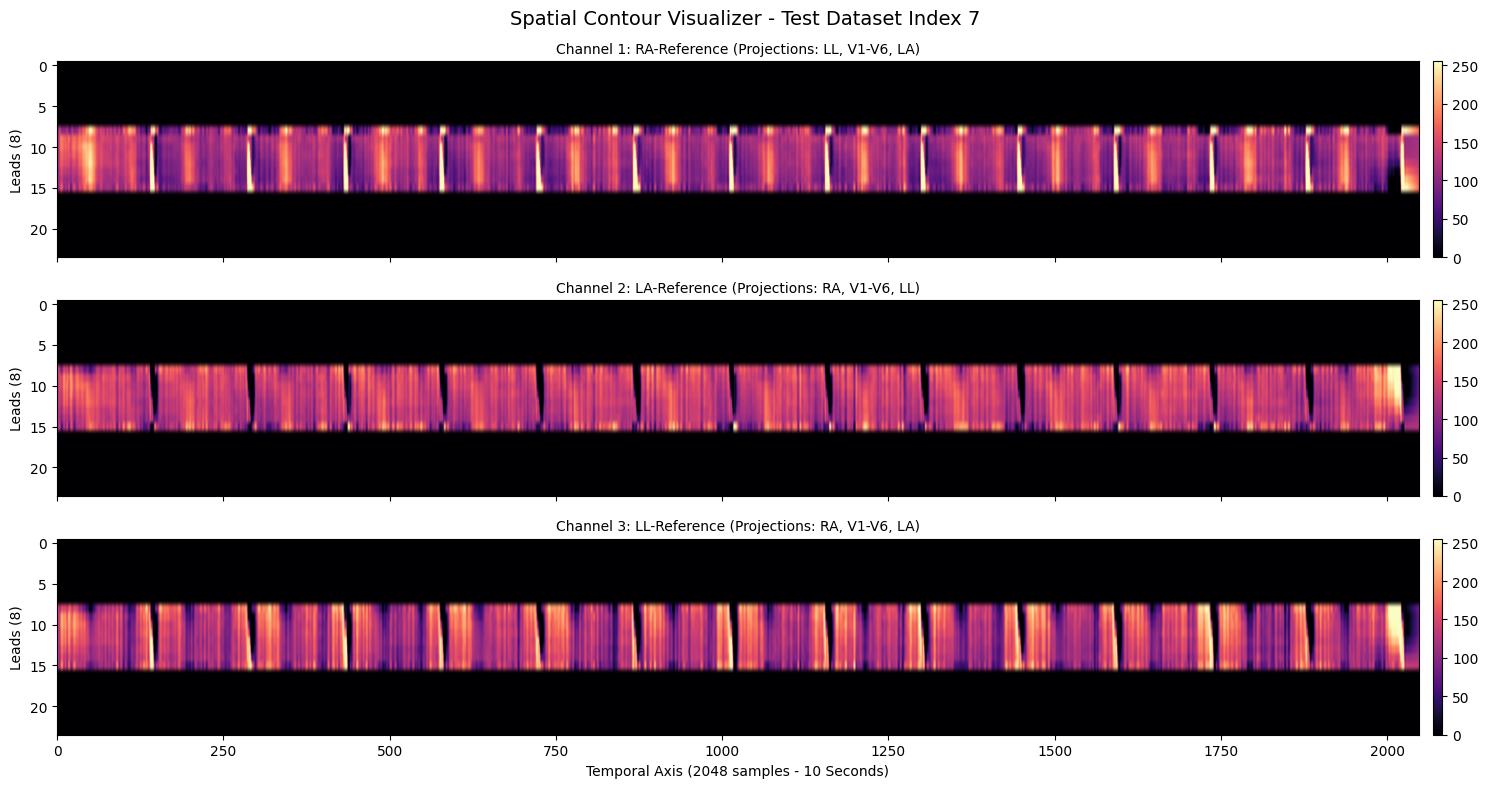


   INFERENCE REPORT: Test Dataset Index 7
Ground Truth    : NEGATIVE (0.00)
Model Prediction : NEGATIVE
Confidence Level : 35.89%



In [13]:
# =========================
# Cell 7 — Visual Debugger: RA/LA/LL Contours & Model Inference
# =========================
import matplotlib.pyplot as plt
import numpy as np
import torch
from pathlib import Path

def run_inference(img_tensor, label=None, record_info="Manual Test"):
    model.eval()
    img_batch = img_tensor.unsqueeze(0).to(device)
    
    # 1. Run Inference
    with torch.no_grad():
        logits = model(img_batch)
        probability = torch.sigmoid(logits).item()
    
    # 2. Visualization of the 3 RA/LA/LL Channels
    fig, axes = plt.subplots(3, 1, figsize=(15, 8), sharex=True)
    channel_names = [
        "Channel 1: RA-Reference (Projections: LL, V1-V6, LA)",
        "Channel 2: LA-Reference (Projections: RA, V1-V6, LL)",
        "Channel 3: LL-Reference (Projections: RA, V1-V6, LA)"
    ]
    
    # Convert back from normalized [-1, 1] to [0, 255] for visual clarity
    display_img = ((img_tensor.cpu().numpy() + 1.0) * 127.5).astype(np.uint8)
    
    for i in range(3):
        # We display each 8-row lead-contour stack
        img_plot = axes[i].imshow(display_img[i], aspect='auto', cmap='magma')
        axes[i].set_title(channel_names[i], fontsize=10)
        axes[i].set_ylabel("Leads (8)")
        plt.colorbar(img_plot, ax=axes[i], fraction=0.01, pad=0.01)
    
    plt.xlabel("Temporal Axis (2048 samples - 10 Seconds)")
    plt.suptitle(f"Spatial Contour Visualizer - {record_info}", fontsize=14)
    plt.tight_layout()
    plt.show()

    # 3. Final Report
    print(f"\n" + "="*30)
    print(f"   INFERENCE REPORT: {record_info}")
    print("="*30)
    if label is not None:
        print(f"Ground Truth    : {'POSITIVE' if label > 0.5 else 'NEGATIVE'} ({label:.2f})")
    print(f"Model Prediction : {'POSITIVE' if probability > 0.5 else 'NEGATIVE'}")
    print(f"Confidence Level : {probability*100:.2f}%")
    print("="*30 + "\n")

# --- CHOOSE YOUR MODE ---
MANUAL_PATH = "" # e.g., "data/processed/2d_images/code15/1000010_img.npy"

if MANUAL_PATH:
    # Manual mode: Enter any relative path to an .npy file
    full_path = PROJECT_ROOT / Path(MANUAL_PATH.replace("\\", "/"))
    if full_path.exists():
        raw_img = np.load(full_path).astype(np.float32)
        # Apply the exact normalization used in Cell 3
        norm_img = torch.from_numpy((raw_img / 127.5) - 1.0)
        run_inference(norm_img, record_info=f"File: {full_path.name}")
    else:
        print(f"❌ Error: File not found at {full_path}")
else:
    # Random Test mode: Pick a record from your loaded test dataset
    idx = np.random.randint(0, len(test_ds))
    img_t, lbl = test_ds[idx]
    run_inference(img_t, label=lbl, record_info=f"Test Dataset Index {idx}")